# Architektur Neuronales Netz

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torchvision.transforms import Normalize
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            #nn.LayerNorm(hidden1_size),
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            #nn.LayerNorm(hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            #nn.LayerNorm(hidden3_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 200, 1)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=200, out_features=1, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs xi
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
xi = torch.tensor(res['xi'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = xi.reshape((-1,1))
# print(x_input.size())
# print(len(x_input))

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test -mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität
# #Preprocessing Normalisierung
# mean_in = torch.tensor(0)
# var_in = torch.tensor(0)
# print(train_dataset[0][0])
# for i in range(len(train_dataset)):
#     mean_in = mean_in + train_dataset[i][0]
#     print(mean_in)
# mean_in = mean_in / len(train_dataset)
# print(mean_in)
# for i in range(len(train_dataset)):
#     var_in = var_in + (train_dataset[i][0] - mean_in)**2
#     print(var_in)
    
# var_in = var_in / len(train_dataset)
# print('Var:', var_in)
# std_in = (var_in)**(1/2)
# print(std_in)
# print((train_dataset[0][0]-mean_in) / std_in)
# train_dataset_norm = ((train_dataset[0][0]-mean_in) / std_in)
# for i in range(1,len(train_dataset)):
#     norm_data = (train_dataset[i][0] - mean_in) / std_in
#     #print(norm_data)
#     train_dataset_norm = torch.cat((train_dataset_norm, norm_data), 0)
# #Normalize(mean = [mean_in, 1], std = [std_in, 1])
# print(train_dataset_norm.size())
# print(train_dataset_norm[0])
# print(train_dataset_norm[1])


# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 1)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            #MRE += MRELoss(pred, y)
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn(pred * std_out + mean_out, y * std_out + mean_out)

            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i] * std_out + mean_out) - (y[i] * std_out + mean_out)) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches
        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MAE: {MAE:>8f}, MRE: {MRE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

Epoch 1/200, Iteration 1/12, Loss: 0.9030
Epoch 1/200, Iteration 2/12, Loss: 1.0819
Epoch 1/200, Iteration 3/12, Loss: 2.9598
Epoch 1/200, Iteration 4/12, Loss: 2.2581
Epoch 1/200, Iteration 5/12, Loss: 1.3878
Epoch 1/200, Iteration 6/12, Loss: 0.4357
Epoch 1/200, Iteration 7/12, Loss: 0.5467
Epoch 1/200, Iteration 8/12, Loss: 0.7371
Epoch 1/200, Iteration 9/12, Loss: 0.6618
Epoch 1/200, Iteration 10/12, Loss: 0.3881
Epoch 1/200, Iteration 11/12, Loss: 0.4709
Epoch 1/200, Iteration 12/12, Loss: 0.5676
Epoch 1/200, Iteration 13/12, Loss: 0.6388
Train Error: 
 Accuracy: 41.38%, Avg loss: 0.503407, MAE: 0.049267, MRE: 1.995685 

Test Error: 
 Accuracy: 43.0%, Avg loss: 0.526534, MAE: 0.051530, MRE: 2.861600 

Epoch 2/200, Iteration 1/12, Loss: 0.5594
Epoch 2/200, Iteration 2/12, Loss: 0.5082
Epoch 2/200, Iteration 3/12, Loss: 0.5361
Epoch 2/200, Iteration 4/12, Loss: 0.3776
Epoch 2/200, Iteration 5/12, Loss: 0.4671
Epoch 2/200, Iteration 6/12, Loss: 0.3557
Epoch 2/200, Iteration 7/12, Los

Train Error: 
 Accuracy: 64.88%, Avg loss: 0.106471, MAE: 0.010420, MRE: 0.453674 

Test Error: 
 Accuracy: 66.5%, Avg loss: 0.098450, MAE: 0.009635, MRE: 0.827034 

Epoch 13/200, Iteration 1/12, Loss: 0.0985
Epoch 13/200, Iteration 2/12, Loss: 0.1043
Epoch 13/200, Iteration 3/12, Loss: 0.1150
Epoch 13/200, Iteration 4/12, Loss: 0.0495
Epoch 13/200, Iteration 5/12, Loss: 0.1056
Epoch 13/200, Iteration 6/12, Loss: 0.0732
Epoch 13/200, Iteration 7/12, Loss: 0.0767
Epoch 13/200, Iteration 8/12, Loss: 0.0666
Epoch 13/200, Iteration 9/12, Loss: 0.0766
Epoch 13/200, Iteration 10/12, Loss: 0.0810
Epoch 13/200, Iteration 11/12, Loss: 0.0645
Epoch 13/200, Iteration 12/12, Loss: 0.1202
Epoch 13/200, Iteration 13/12, Loss: 0.1194
Train Error: 
 Accuracy: 96.0%, Avg loss: 0.143462, MAE: 0.014040, MRE: 0.924209 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.155062, MAE: 0.015175, MRE: 1.787640 

Epoch 14/200, Iteration 1/12, Loss: 0.1543
Epoch 14/200, Iteration 2/12, Loss: 0.1228
Epoch 14/200, Iterat

Epoch 24/200, Iteration 12/12, Loss: 0.1070
Epoch 24/200, Iteration 13/12, Loss: 0.0798
Train Error: 
 Accuracy: 70.25%, Avg loss: 0.131502, MAE: 0.012870, MRE: 0.606866 

Test Error: 
 Accuracy: 68.0%, Avg loss: 0.137853, MAE: 0.013491, MRE: 2.372030 

Epoch 25/200, Iteration 1/12, Loss: 0.1204
Epoch 25/200, Iteration 2/12, Loss: 0.1410
Epoch 25/200, Iteration 3/12, Loss: 0.1105
Epoch 25/200, Iteration 4/12, Loss: 0.1684
Epoch 25/200, Iteration 5/12, Loss: 0.1036
Epoch 25/200, Iteration 6/12, Loss: 0.1024
Epoch 25/200, Iteration 7/12, Loss: 0.1268
Epoch 25/200, Iteration 8/12, Loss: 0.0982
Epoch 25/200, Iteration 9/12, Loss: 0.1246
Epoch 25/200, Iteration 10/12, Loss: 0.1059
Epoch 25/200, Iteration 11/12, Loss: 0.0916
Epoch 25/200, Iteration 12/12, Loss: 0.0945
Epoch 25/200, Iteration 13/12, Loss: 0.0888
Train Error: 
 Accuracy: 95.38%, Avg loss: 0.091606, MAE: 0.008965, MRE: 0.378662 

Test Error: 
 Accuracy: 93.5%, Avg loss: 0.085862, MAE: 0.008403, MRE: 0.753517 

Epoch 26/200, Ite

Epoch 36/200, Iteration 8/12, Loss: 0.1190
Epoch 36/200, Iteration 9/12, Loss: 0.0919
Epoch 36/200, Iteration 10/12, Loss: 0.1546
Epoch 36/200, Iteration 11/12, Loss: 0.1377
Epoch 36/200, Iteration 12/12, Loss: 0.1180
Epoch 36/200, Iteration 13/12, Loss: 0.0981
Train Error: 
 Accuracy: 62.38%, Avg loss: 0.127309, MAE: 0.012459, MRE: 0.466258 

Test Error: 
 Accuracy: 62.5%, Avg loss: 0.126304, MAE: 0.012361, MRE: 1.603272 

Epoch 37/200, Iteration 1/12, Loss: 0.1334
Epoch 37/200, Iteration 2/12, Loss: 0.1123
Epoch 37/200, Iteration 3/12, Loss: 0.0975
Epoch 37/200, Iteration 4/12, Loss: 0.1441
Epoch 37/200, Iteration 5/12, Loss: 0.0596
Epoch 37/200, Iteration 6/12, Loss: 0.1295
Epoch 37/200, Iteration 7/12, Loss: 0.0697
Epoch 37/200, Iteration 8/12, Loss: 0.1398
Epoch 37/200, Iteration 9/12, Loss: 0.1203
Epoch 37/200, Iteration 10/12, Loss: 0.1383
Epoch 37/200, Iteration 11/12, Loss: 0.1199
Epoch 37/200, Iteration 12/12, Loss: 0.1399
Epoch 37/200, Iteration 13/12, Loss: 0.1297
Train Err

Train Error: 
 Accuracy: 95.88%, Avg loss: 0.043346, MAE: 0.004242, MRE: 0.230122 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.044070, MAE: 0.004313, MRE: 0.624375 

Epoch 48/200, Iteration 1/12, Loss: 0.0492
Epoch 48/200, Iteration 2/12, Loss: 0.0379
Epoch 48/200, Iteration 3/12, Loss: 0.0427
Epoch 48/200, Iteration 4/12, Loss: 0.0452
Epoch 48/200, Iteration 5/12, Loss: 0.0422
Epoch 48/200, Iteration 6/12, Loss: 0.0389
Epoch 48/200, Iteration 7/12, Loss: 0.0423
Epoch 48/200, Iteration 8/12, Loss: 0.0380
Epoch 48/200, Iteration 9/12, Loss: 0.0399
Epoch 48/200, Iteration 10/12, Loss: 0.0383
Epoch 48/200, Iteration 11/12, Loss: 0.0414
Epoch 48/200, Iteration 12/12, Loss: 0.0411
Epoch 48/200, Iteration 13/12, Loss: 0.0480
Train Error: 
 Accuracy: 97.12%, Avg loss: 0.036508, MAE: 0.003573, MRE: 0.191150 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.040650, MAE: 0.003978, MRE: 0.368047 

Epoch 49/200, Iteration 1/12, Loss: 0.0428
Epoch 49/200, Iteration 2/12, Loss: 0.0354
Epoch 49/200, Itera

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.030787, MAE: 0.003013, MRE: 0.209164 

Epoch 60/200, Iteration 1/12, Loss: 0.0202
Epoch 60/200, Iteration 2/12, Loss: 0.0175
Epoch 60/200, Iteration 3/12, Loss: 0.0208
Epoch 60/200, Iteration 4/12, Loss: 0.0145
Epoch 60/200, Iteration 5/12, Loss: 0.0199
Epoch 60/200, Iteration 6/12, Loss: 0.0189
Epoch 60/200, Iteration 7/12, Loss: 0.0201
Epoch 60/200, Iteration 8/12, Loss: 0.0186
Epoch 60/200, Iteration 9/12, Loss: 0.0190
Epoch 60/200, Iteration 10/12, Loss: 0.0159
Epoch 60/200, Iteration 11/12, Loss: 0.0184
Epoch 60/200, Iteration 12/12, Loss: 0.0213
Epoch 60/200, Iteration 13/12, Loss: 0.0219
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.015615, MAE: 0.001528, MRE: 0.076601 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.025669, MAE: 0.002512, MRE: 0.192369 

Epoch 61/200, Iteration 1/12, Loss: 0.0125
Epoch 61/200, Iteration 2/12, Loss: 0.0136
Epoch 61/200, Iteration 3/12, Loss: 0.0194
Epoch 61/200, Iteration 4/12, Loss: 0.0228
Epoch 61/200, It

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.021930, MAE: 0.002146, MRE: 0.087622 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.025368, MAE: 0.002483, MRE: 0.365176 

Epoch 72/200, Iteration 1/12, Loss: 0.0209
Epoch 72/200, Iteration 2/12, Loss: 0.0195
Epoch 72/200, Iteration 3/12, Loss: 0.0149
Epoch 72/200, Iteration 4/12, Loss: 0.0180
Epoch 72/200, Iteration 5/12, Loss: 0.0142
Epoch 72/200, Iteration 6/12, Loss: 0.0196
Epoch 72/200, Iteration 7/12, Loss: 0.0166
Epoch 72/200, Iteration 8/12, Loss: 0.0142
Epoch 72/200, Iteration 9/12, Loss: 0.0161
Epoch 72/200, Iteration 10/12, Loss: 0.0138
Epoch 72/200, Iteration 11/12, Loss: 0.0156
Epoch 72/200, Iteration 12/12, Loss: 0.0176
Epoch 72/200, Iteration 13/12, Loss: 0.0149
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.016685, MAE: 0.001633, MRE: 0.098403 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.026470, MAE: 0.002591, MRE: 0.351650 

Epoch 73/200, Iteration 1/12, Loss: 0.0165
Epoch 73/200, Iteration 2/12, Loss: 0.0143
Epoch 73/200, Itera

Epoch 83/200, Iteration 5/12, Loss: 0.0187
Epoch 83/200, Iteration 6/12, Loss: 0.0170
Epoch 83/200, Iteration 7/12, Loss: 0.0131
Epoch 83/200, Iteration 8/12, Loss: 0.0131
Epoch 83/200, Iteration 9/12, Loss: 0.0123
Epoch 83/200, Iteration 10/12, Loss: 0.0158
Epoch 83/200, Iteration 11/12, Loss: 0.0196
Epoch 83/200, Iteration 12/12, Loss: 0.0159
Epoch 83/200, Iteration 13/12, Loss: 0.0093
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.013182, MAE: 0.001290, MRE: 0.083453 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.020529, MAE: 0.002009, MRE: 0.315802 

Epoch 84/200, Iteration 1/12, Loss: 0.0138
Epoch 84/200, Iteration 2/12, Loss: 0.0174
Epoch 84/200, Iteration 3/12, Loss: 0.0163
Epoch 84/200, Iteration 4/12, Loss: 0.0190
Epoch 84/200, Iteration 5/12, Loss: 0.0155
Epoch 84/200, Iteration 6/12, Loss: 0.0119
Epoch 84/200, Iteration 7/12, Loss: 0.0151
Epoch 84/200, Iteration 8/12, Loss: 0.0124
Epoch 84/200, Iteration 9/12, Loss: 0.0127
Epoch 84/200, Iteration 10/12, Loss: 0.0146
Epoch 84/200

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.005683, MAE: 0.000556, MRE: 0.036270 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.017280, MAE: 0.001691, MRE: 0.236627 

Epoch 96/200, Iteration 1/12, Loss: 0.0043
Epoch 96/200, Iteration 2/12, Loss: 0.0057
Epoch 96/200, Iteration 3/12, Loss: 0.0060
Epoch 96/200, Iteration 4/12, Loss: 0.0061
Epoch 96/200, Iteration 5/12, Loss: 0.0061
Epoch 96/200, Iteration 6/12, Loss: 0.0053
Epoch 96/200, Iteration 7/12, Loss: 0.0056
Epoch 96/200, Iteration 8/12, Loss: 0.0056
Epoch 96/200, Iteration 9/12, Loss: 0.0066
Epoch 96/200, Iteration 10/12, Loss: 0.0063
Epoch 96/200, Iteration 11/12, Loss: 0.0053
Epoch 96/200, Iteration 12/12, Loss: 0.0067
Epoch 96/200, Iteration 13/12, Loss: 0.0047
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.006051, MAE: 0.000592, MRE: 0.038633 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.017107, MAE: 0.001674, MRE: 0.267409 

Epoch 97/200, Iteration 1/12, Loss: 0.0057
Epoch 97/200, Iteration 2/12, Loss: 0.0057
Epoch 97/200, Itera

Epoch 107/200, Iteration 6/12, Loss: 0.0063
Epoch 107/200, Iteration 7/12, Loss: 0.0043
Epoch 107/200, Iteration 8/12, Loss: 0.0055
Epoch 107/200, Iteration 9/12, Loss: 0.0050
Epoch 107/200, Iteration 10/12, Loss: 0.0055
Epoch 107/200, Iteration 11/12, Loss: 0.0062
Epoch 107/200, Iteration 12/12, Loss: 0.0053
Epoch 107/200, Iteration 13/12, Loss: 0.0069
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.005721, MAE: 0.000560, MRE: 0.034400 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.018001, MAE: 0.001762, MRE: 0.267487 

Epoch 108/200, Iteration 1/12, Loss: 0.0056
Epoch 108/200, Iteration 2/12, Loss: 0.0078
Epoch 108/200, Iteration 3/12, Loss: 0.0070
Epoch 108/200, Iteration 4/12, Loss: 0.0051
Epoch 108/200, Iteration 5/12, Loss: 0.0042
Epoch 108/200, Iteration 6/12, Loss: 0.0059
Epoch 108/200, Iteration 7/12, Loss: 0.0067
Epoch 108/200, Iteration 8/12, Loss: 0.0048
Epoch 108/200, Iteration 9/12, Loss: 0.0051
Epoch 108/200, Iteration 10/12, Loss: 0.0046
Epoch 108/200, Iteration 11/12, Loss:

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.004839, MAE: 0.000474, MRE: 0.030709 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.017134, MAE: 0.001677, MRE: 0.252079 

Epoch 120/200, Iteration 1/12, Loss: 0.0039
Epoch 120/200, Iteration 2/12, Loss: 0.0043
Epoch 120/200, Iteration 3/12, Loss: 0.0051
Epoch 120/200, Iteration 4/12, Loss: 0.0050
Epoch 120/200, Iteration 5/12, Loss: 0.0060
Epoch 120/200, Iteration 6/12, Loss: 0.0064
Epoch 120/200, Iteration 7/12, Loss: 0.0052
Epoch 120/200, Iteration 8/12, Loss: 0.0048
Epoch 120/200, Iteration 9/12, Loss: 0.0054
Epoch 120/200, Iteration 10/12, Loss: 0.0055
Epoch 120/200, Iteration 11/12, Loss: 0.0066
Epoch 120/200, Iteration 12/12, Loss: 0.0040
Epoch 120/200, Iteration 13/12, Loss: 0.0051
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.005063, MAE: 0.000496, MRE: 0.031708 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.017017, MAE: 0.001665, MRE: 0.221934 

Epoch 121/200, Iteration 1/12, Loss: 0.0063
Epoch 121/200, Iteration 2/12, Loss: 0.0047
Epoc

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.016440, MAE: 0.001609, MRE: 0.292891 

Epoch 132/200, Iteration 1/12, Loss: 0.0073
Epoch 132/200, Iteration 2/12, Loss: 0.0035
Epoch 132/200, Iteration 3/12, Loss: 0.0043
Epoch 132/200, Iteration 4/12, Loss: 0.0045
Epoch 132/200, Iteration 5/12, Loss: 0.0043
Epoch 132/200, Iteration 6/12, Loss: 0.0052
Epoch 132/200, Iteration 7/12, Loss: 0.0047
Epoch 132/200, Iteration 8/12, Loss: 0.0045
Epoch 132/200, Iteration 9/12, Loss: 0.0044
Epoch 132/200, Iteration 10/12, Loss: 0.0051
Epoch 132/200, Iteration 11/12, Loss: 0.0053
Epoch 132/200, Iteration 12/12, Loss: 0.0052
Epoch 132/200, Iteration 13/12, Loss: 0.0057
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.005169, MAE: 0.000506, MRE: 0.032486 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.016634, MAE: 0.001628, MRE: 0.268468 

Epoch 133/200, Iteration 1/12, Loss: 0.0049
Epoch 133/200, Iteration 2/12, Loss: 0.0060
Epoch 133/200, Iteration 3/12, Loss: 0.0047
Epoch 133/200, Iteration 4/12, Loss: 0.0046


Epoch 144/200, Iteration 9/12, Loss: 0.0048
Epoch 144/200, Iteration 10/12, Loss: 0.0062
Epoch 144/200, Iteration 11/12, Loss: 0.0044
Epoch 144/200, Iteration 12/12, Loss: 0.0050
Epoch 144/200, Iteration 13/12, Loss: 0.0055
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.005603, MAE: 0.000548, MRE: 0.032857 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.016154, MAE: 0.001581, MRE: 0.300643 

Epoch 145/200, Iteration 1/12, Loss: 0.0066
Epoch 145/200, Iteration 2/12, Loss: 0.0052
Epoch 145/200, Iteration 3/12, Loss: 0.0037
Epoch 145/200, Iteration 4/12, Loss: 0.0053
Epoch 145/200, Iteration 5/12, Loss: 0.0053
Epoch 145/200, Iteration 6/12, Loss: 0.0052
Epoch 145/200, Iteration 7/12, Loss: 0.0040
Epoch 145/200, Iteration 8/12, Loss: 0.0040
Epoch 145/200, Iteration 9/12, Loss: 0.0057
Epoch 145/200, Iteration 10/12, Loss: 0.0074
Epoch 145/200, Iteration 11/12, Loss: 0.0047
Epoch 145/200, Iteration 12/12, Loss: 0.0055
Epoch 145/200, Iteration 13/12, Loss: 0.0071
Train Error: 
 Accuracy: 100.0%, A

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.017247, MAE: 0.001688, MRE: 0.260675 

Epoch 156/200, Iteration 1/12, Loss: 0.0050
Epoch 156/200, Iteration 2/12, Loss: 0.0044
Epoch 156/200, Iteration 3/12, Loss: 0.0042
Epoch 156/200, Iteration 4/12, Loss: 0.0044
Epoch 156/200, Iteration 5/12, Loss: 0.0069
Epoch 156/200, Iteration 6/12, Loss: 0.0048
Epoch 156/200, Iteration 7/12, Loss: 0.0046
Epoch 156/200, Iteration 8/12, Loss: 0.0046
Epoch 156/200, Iteration 9/12, Loss: 0.0043
Epoch 156/200, Iteration 10/12, Loss: 0.0057
Epoch 156/200, Iteration 11/12, Loss: 0.0055
Epoch 156/200, Iteration 12/12, Loss: 0.0056
Epoch 156/200, Iteration 13/12, Loss: 0.0034
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.004762, MAE: 0.000466, MRE: 0.030035 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.016067, MAE: 0.001572, MRE: 0.230182 

Epoch 157/200, Iteration 1/12, Loss: 0.0041
Epoch 157/200, Iteration 2/12, Loss: 0.0049
Epoch 157/200, Iteration 3/12, Loss: 0.0066
Epoch 157/200, Iteration 4/12, Loss: 0.0044


Epoch 167/200, Iteration 6/12, Loss: 0.0026
Epoch 167/200, Iteration 7/12, Loss: 0.0034
Epoch 167/200, Iteration 8/12, Loss: 0.0043
Epoch 167/200, Iteration 9/12, Loss: 0.0025
Epoch 167/200, Iteration 10/12, Loss: 0.0037
Epoch 167/200, Iteration 11/12, Loss: 0.0032
Epoch 167/200, Iteration 12/12, Loss: 0.0040
Epoch 167/200, Iteration 13/12, Loss: 0.0041
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.003300, MAE: 0.000323, MRE: 0.024742 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.016003, MAE: 0.001566, MRE: 0.254811 

Epoch 168/200, Iteration 1/12, Loss: 0.0031
Epoch 168/200, Iteration 2/12, Loss: 0.0048
Epoch 168/200, Iteration 3/12, Loss: 0.0031
Epoch 168/200, Iteration 4/12, Loss: 0.0035
Epoch 168/200, Iteration 5/12, Loss: 0.0029
Epoch 168/200, Iteration 6/12, Loss: 0.0038
Epoch 168/200, Iteration 7/12, Loss: 0.0032
Epoch 168/200, Iteration 8/12, Loss: 0.0024
Epoch 168/200, Iteration 9/12, Loss: 0.0037
Epoch 168/200, Iteration 10/12, Loss: 0.0031
Epoch 168/200, Iteration 11/12, Loss:

Epoch 179/200, Iteration 13/12, Loss: 0.0033
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.003262, MAE: 0.000319, MRE: 0.024798 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.015888, MAE: 0.001555, MRE: 0.249529 

Epoch 180/200, Iteration 1/12, Loss: 0.0035
Epoch 180/200, Iteration 2/12, Loss: 0.0026
Epoch 180/200, Iteration 3/12, Loss: 0.0037
Epoch 180/200, Iteration 4/12, Loss: 0.0044
Epoch 180/200, Iteration 5/12, Loss: 0.0026
Epoch 180/200, Iteration 6/12, Loss: 0.0029
Epoch 180/200, Iteration 7/12, Loss: 0.0034
Epoch 180/200, Iteration 8/12, Loss: 0.0032
Epoch 180/200, Iteration 9/12, Loss: 0.0032
Epoch 180/200, Iteration 10/12, Loss: 0.0024
Epoch 180/200, Iteration 11/12, Loss: 0.0040
Epoch 180/200, Iteration 12/12, Loss: 0.0029
Epoch 180/200, Iteration 13/12, Loss: 0.0039
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.003200, MAE: 0.000313, MRE: 0.024388 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.015937, MAE: 0.001560, MRE: 0.254617 

Epoch 181/200, Iteration 1/12, Loss: 0.0026
Epo

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.003116, MAE: 0.000305, MRE: 0.023944 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.015934, MAE: 0.001559, MRE: 0.252505 

Epoch 191/200, Iteration 1/12, Loss: 0.0050
Epoch 191/200, Iteration 2/12, Loss: 0.0038
Epoch 191/200, Iteration 3/12, Loss: 0.0034
Epoch 191/200, Iteration 4/12, Loss: 0.0035
Epoch 191/200, Iteration 5/12, Loss: 0.0044
Epoch 191/200, Iteration 6/12, Loss: 0.0025
Epoch 191/200, Iteration 7/12, Loss: 0.0022
Epoch 191/200, Iteration 8/12, Loss: 0.0027
Epoch 191/200, Iteration 9/12, Loss: 0.0022
Epoch 191/200, Iteration 10/12, Loss: 0.0030
Epoch 191/200, Iteration 11/12, Loss: 0.0027
Epoch 191/200, Iteration 12/12, Loss: 0.0032
Epoch 191/200, Iteration 13/12, Loss: 0.0023
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.003104, MAE: 0.000304, MRE: 0.024329 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.015928, MAE: 0.001559, MRE: 0.250650 

Epoch 192/200, Iteration 1/12, Loss: 0.0033
Epoch 192/200, Iteration 2/12, Loss: 0.0025
Epoc

#### Plots loss vs Epoch

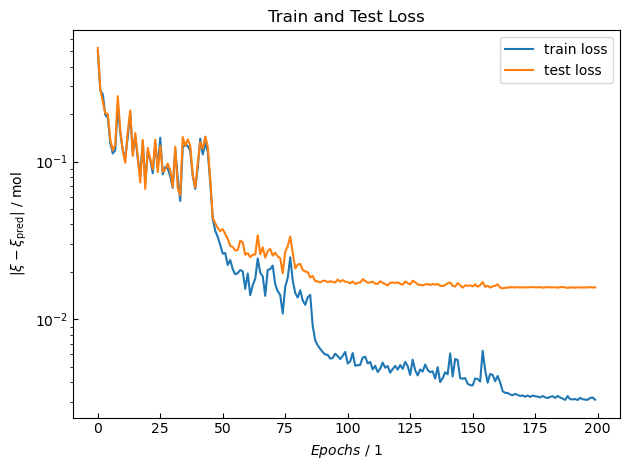

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2 = 0.9999686632259802
Test Dataset: R^2 = 0.999294606577944
Max Error Training: |xi - xi_pred| = 0.003286003552151362
Max Error Test: |xi - xi_pred| = 0.01748302294858095


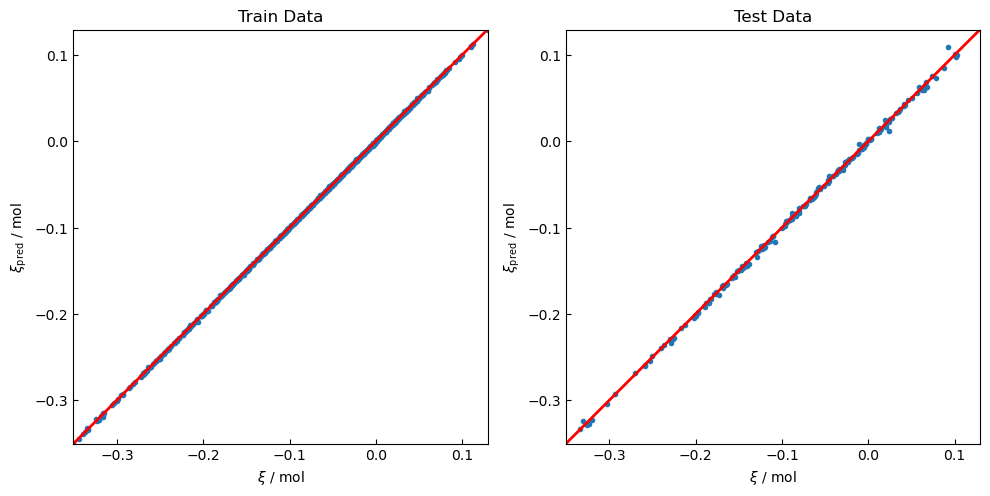

In [11]:
xi_real_norm = []
xi_pred_norm = []
for (X,y) in train_dataloader:
    xi_real_norm = np.append(xi_real_norm, y.numpy())
    xi_pred_norm = np.append(xi_pred_norm, net(X).detach().numpy())

xi_real_test_norm = []
xi_pred_test_norm = []
for (X,y) in test_dataloader:
    xi_real_test_norm = np.append(xi_real_test_norm, y.numpy())
    xi_pred_test_norm = np.append(xi_pred_test_norm, net(X).detach().numpy())

xi_real = xi_real_norm * std_out.numpy() + mean_out.numpy()
xi_pred = xi_pred_norm * std_out.numpy() + mean_out.numpy()
xi_real_test = xi_real_test_norm * std_out.numpy() + mean_out.numpy()
xi_pred_test = xi_pred_test_norm * std_out.numpy() + mean_out.numpy()

print('Training Dataset: R^2 =', r2(xi_real,xi_pred))
print('Test Dataset: R^2 =', r2(xi_real_test,xi_pred_test))
print('Max Error Training: |xi - xi_pred| =', max_error(xi_real, xi_pred))
print('Max Error Test: |xi - xi_pred| =', max_error(xi_real_test, xi_pred_test))

# find the boundaries of X and Y values
bounds = (min(xi_real.min(), xi_pred.min()) - int(0.1 * xi_pred.min()), max(xi_real.max(), xi_pred.max())+ int(0.1 * xi_pred.max()))

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(xi_real, xi_pred, '.')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(xi_real_test, xi_pred_test, '.')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

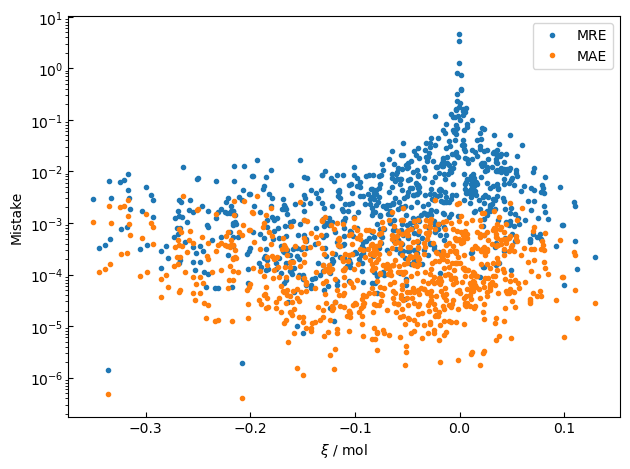

In [12]:
fig,ax = plt.subplots()
ax.semilogy(xi_real, abs((xi_pred - xi_real) / xi_real), '.', label = 'MRE')
ax.semilogy(xi_real, abs(xi_real-xi_pred), '.', label = 'MAE')
ax.set(xlabel = '$\\xi$ / mol', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

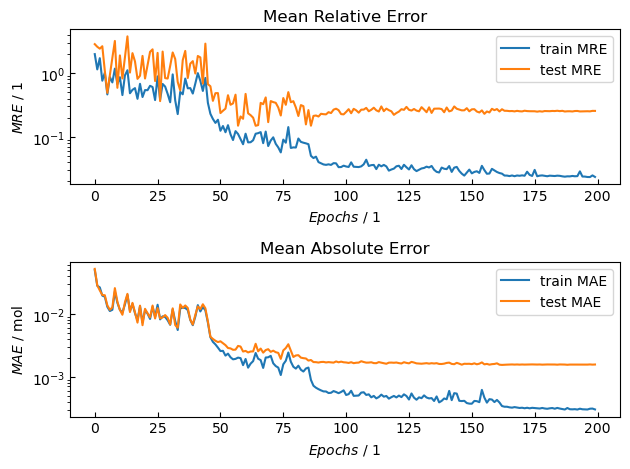

In [21]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE') #
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()


plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

T: -0.8288417738947345
T: 705.1226335148933


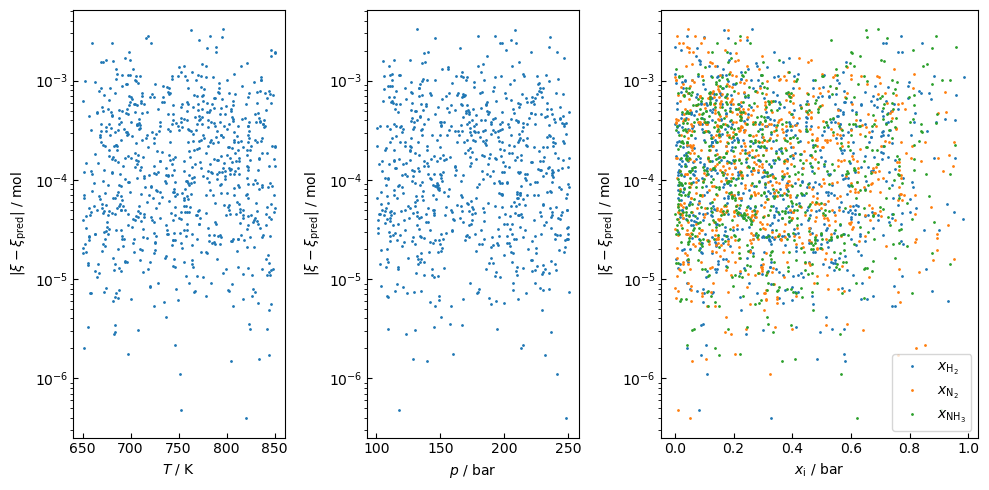

In [14]:
#mistake = []
xi_real_norm = []
xi_pred_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_norm = []
param_x_N2_norm = []
param_x_NH3_norm = []
for X,y in train_dataloader:
    #mistake = np.append(mistake, abs(y - net(X).detach().numpy()))
    xi_real_norm = np.append(xi_real_norm, y)
    xi_pred_norm = np.append(xi_pred_norm, net(X).detach().numpy())
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_norm = np.append(param_x_H2_norm, X[:,2])
    param_x_N2_norm = np.append(param_x_N2_norm, X[:,3])
    param_x_NH3_norm = np.append(param_x_NH3_norm, X[:,4])
    
print('T:', param_T_norm[0])
xi_real = xi_real_norm * std_out.numpy() + mean_out.numpy()
xi_pred = xi_pred_norm * std_out.numpy() + mean_out.numpy()
param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2 = param_x_H2_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2 = param_x_N2_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3 = param_x_NH3_norm * std_in[4].numpy() + mean_in[4].numpy()

mistake = abs(xi_real - xi_pred)
print('T:', param_T[0])

# print(param_T[0])
# print(param_T)
# print(mistake)

fig,ax = plt.subplots(1,3, figsize = (10, 5), gridspec_kw={'width_ratios': [2,2,3]})

ax[0].semilogy(param_T, mistake, '.', markersize = 2)
ax[0].set(xlabel = '$T$ / K', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
#ax[0].set(ylim=(0,max(mistake)))


ax[1].semilogy(param_p, mistake, '.', markersize = 2)
ax[1].set(xlabel = '$p$ / bar', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)

ax[2].semilogy(param_x_H2, mistake, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[2].semilogy(param_x_N2, mistake, '.', markersize = 2, label = '$x\mathregular{_{N_2}}$')
ax[2].semilogy(param_x_NH3, mistake, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[2].set(xlabel = '$x\mathregular{_{i}}$ / bar', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[2].tick_params(direction = 'in') #, length = 20, width = 3)
ax[2].set

plt.legend()
plt.tight_layout()
plt.show()

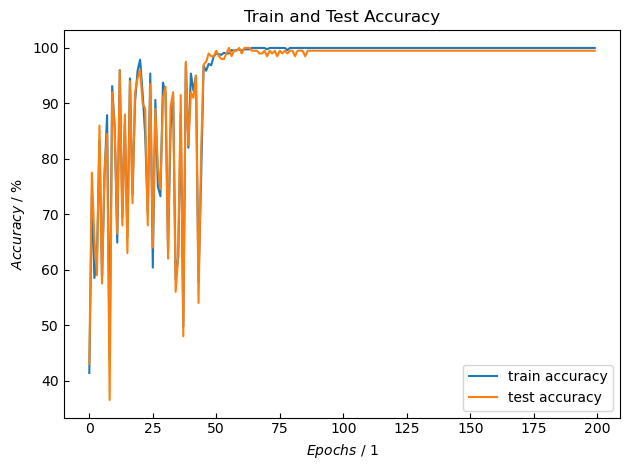

In [15]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [16]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y.reshape((-1,1)))
    print(net(X))
    break

tensor([[-0.2611,  1.2893, -1.1807,  2.6355, -1.3792],
        [ 1.2493, -0.4070, -1.0355,  1.1416, -0.0637],
        [-1.4505, -0.7883, -0.5257,  1.5170, -0.9506],
        [-0.8936,  1.3868,  1.4961, -0.2535, -1.2752],
        [ 1.7140,  0.0721, -1.1412, -0.9127,  2.0562],
        [ 0.5697,  0.8436, -0.7395, -0.6962,  1.4350],
        [-1.5375, -0.0639,  0.9486, -0.5556, -0.4218],
        [ 1.0081, -0.9500,  1.3486, -0.4378, -0.9446],
        [ 1.4003, -1.4790, -1.1669,  0.9685,  0.2397],
        [-0.8039, -0.2114,  0.2684,  0.3936, -0.6588],
        [-1.4845,  1.3452, -0.2065, -0.0958,  0.3042],
        [ 0.9341,  1.0604,  1.7701, -0.8955, -0.9255],
        [-0.7508,  0.7586, -1.0938,  1.5510, -0.4054],
        [ 1.4183,  0.5585,  0.0943,  0.1015, -0.1955],
        [-1.3852,  0.7439, -1.2614,  1.6419, -0.3238],
        [ 0.2084, -1.6560, -0.8285, -0.0973,  0.9390],
        [-1.2329,  0.9759, -0.9074,  1.0594, -0.1137],
        [-0.1083,  0.7982, -0.0850, -0.8485,  0.9177],
        [ 

#### Einblick in Netzwerk

In [17]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[ 1.3938e-01,  1.8360e-02,  2.7513e-01, -1.0031e-01, -3.5354e-01],
         [-3.0382e-01, -5.2622e-02, -9.0647e-02, -4.7398e-01,  7.1013e-02],
         [ 2.9652e-01, -1.1931e-01, -3.6963e-01,  8.5119e-03,  8.5800e-02],
         [ 2.1095e-01,  1.4175e-02,  3.6109e-01,  4.8985e-01,  2.9738e-01],
         [-1.6353e-01,  1.3262e-01, -4.4619e-01, -1.6157e-01,  3.3527e-01],
         [-2.1296e-01, -2.5416e-01, -2.1938e-01,  3.1194e-01, -3.8918e-01],
         [ 7.3973e-02,  6.7459e-02, -1.4969e-01,  2.4813e-02,  1.8115e-01],
         [ 6.5322e-02,  2.3690e-02,  4.8282e-01,  3.3531e-01, -3.0206e-01],
         [-2.4357e-01, -9.3871e-02, -1.3391e-01, -3.0263e-01,  9.2214e-02],
         [-3.4719e-02,  1.3696e-01,  2.9192e-01, -2.9935e-01, -2.7531e-01],
         [ 4.3631e-01,  4.5893e-02, -4.4333e-02,  1.3044e-01,  1.0812e-01],
         [ 4.1099e-01, -1.0522e-01, -1.5138e-02,  3.6309e-01,  3.8299e-01],
         [ 3.3615e-01, -2.5389e-01, -3.5583e-01, -1.6921e-01, -4.

In [18]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.8489, 0.4886, 0.9673, 0.9770, 0.9156],
        [0.3656, 0.4994, 0.5516, 0.8840, 0.3011]])
tensor([[-0.2524],
        [ 0.1673]], grad_fn=<AddmmBackward0>)


In [19]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [20]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[-0.3219,  1.0728, -1.1453, -0.8314,  1.9808],
        [-1.1312, -0.6345,  1.6443, -0.3718, -1.3104],
        [ 0.9611,  1.4740, -0.0344, -0.1765,  0.2079],
        [ 1.2872, -1.2085,  1.5217, -0.6420, -0.9208],
        [-1.2452, -1.5959, -1.0865, -0.5219,  1.6177],
        [-0.8346,  0.6596, -0.0718, -0.5113,  0.5740],
        [ 1.6936, -0.2742,  0.0113,  0.3454, -0.3499],
        [-0.6296,  1.4486, -0.5613,  0.2147,  0.3614],
        [-0.9787,  1.1803, -1.0389, -1.2797,  2.3117],
        [ 0.2125,  0.0539, -1.0131,  2.4757, -1.3934],
        [ 1.3384,  1.7104, -1.3467,  1.5003, -0.0982],
        [ 0.0035, -0.1880, -0.4991,  0.2732,  0.2407],
        [ 0.0974, -1.0216, -0.0417, -0.5051,  0.5372],
        [ 1.6182,  1.2586, -0.8616,  2.2016, -1.2792],
        [-0.7752,  1.2022,  0.8897, -0.3892, -0.5249],
        [-0.4886, -0.3058, -1.3573,  2.7044, -1.2668],
        [-0.8288, -0.9916,  1.2679, -0.0845, -1.2084],
        [-0.8915, -1.1901,  1.4270, -0.5577, -0.9069],
        [-

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

#### Histogramme Verteilung von $xi$ und $x{_i}$

In [ ]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()